# Feature Selection

In [4]:
### Load the dictionary containing financial data and some email features (to_ from_poi)
import pickle
with open('data/final_project_dataset.pkl', 'rb') as f:
    fin_data = pickle.load(f)

# Remove 'TOTAL' from data
del fin_data['TOTAL']

### Select features to use based on their importance as estimated by an ExtraTreesClassifier

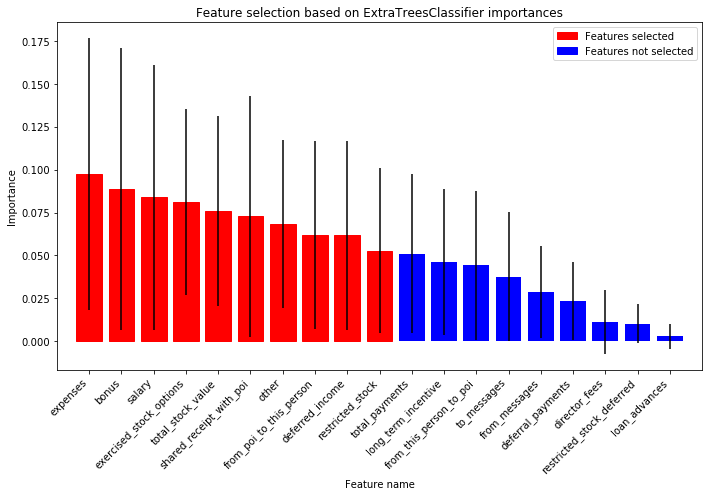

In [5]:
# features_list is a list of feature names in the financial data.
# The first feature must be "poi".

import numpy as np
from tools.feature_format import featureFormat, targetFeatureSplit

def make_features_labels(dataset, feature_names):
    """
    Quick way to split a dataset into features and labels based on feature names
    """
    data = featureFormat(dataset, feature_names, sort_keys = True)
    labels, features = targetFeatureSplit(data)
    labels = np.array(labels)
    features = np.array(features)
    
    return features, labels

# Start with all features except: 'email_address'

all_feature_names = ['poi', 'salary', 'to_messages', 'deferral_payments', 'total_payments',\
'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi',\
'restricted_stock_deferred', 'total_stock_value', 'expenses', 'loan_advances',\
'from_messages', 'other', 'from_this_person_to_poi', 'director_fees', 'deferred_income',\
'long_term_incentive', 'from_poi_to_this_person']

all_features, all_labels = make_features_labels(fin_data, all_feature_names)

# Select the most important features based on ExtraTreesClassifier
from feature_selection import importance_plotter
selected_feature_names = importance_plotter(all_features, all_labels, 
                                            np.array(all_feature_names[1:]), balanced=True)

### Confirm that the feature selection did help performance:

In [6]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit
from sklearn import metrics

# Make features and labels based on the new selection
selected_feature_names.insert(0, 'poi')
selected_features, selected_labels = make_features_labels(fin_data, selected_feature_names)

clf = GaussianNB()
def fit_print_scores(clf, features, labels):
    
    cv = StratifiedShuffleSplit(test_size=0.3, random_state=42)
    f1_scores = cross_val_score(clf, features, labels, cv=5, scoring='f1')
    print '-f1 score: %0.2f (+/- %0.2f)' % (f1_scores.mean(), 
                                           f1_scores.std() * 2)
    precision_scores = cross_val_score(clf, features, labels, cv=5, scoring='precision')
    print '-precision score: %0.2f (+/- %0.2f)' % (precision_scores.mean(), 
                                                  precision_scores.std() * 2)
    recall_scores = cross_val_score(clf, features, labels, cv=5, scoring='recall')
    print '-recall score: %0.2f (+/- %0.2f)' % (recall_scores.mean(), 
                                                  recall_scores.std() * 2)

print 'All features:'
fit_print_scores(clf, all_features, all_labels)
print '\nSelected features:'
fit_print_scores(clf, selected_features, selected_labels)

All features:
-f1 score: 0.24 (+/- 0.27)
-precision score: 0.19 (+/- 0.24)
-recall score: 0.42 (+/- 0.52)

Selected features:
-f1 score: 0.39 (+/- 0.44)
-precision score: 0.37 (+/- 0.39)
-recall score: 0.42 (+/- 0.52)


Looks like this feature selection did, in fact, improve precision performance.

### Plot the most highly correlated features to see if there is any redundancy or outliers 

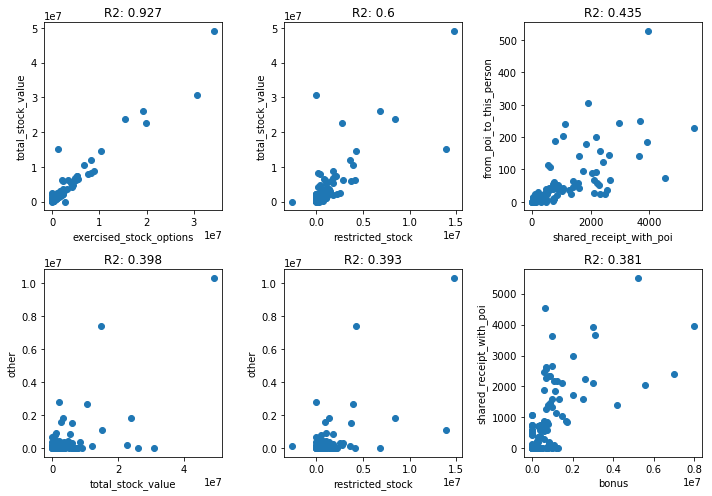

In [7]:
from feature_selection import correlation_plotter
correlation_plotter(selected_feature_names[1:], fin_data)

The correlation graphs show there is a redundancy between total_stock_value and exercised_stock_options. I will not include exercised_stock_options in the feature selection.
There is also a negative outlier in the restricted stock data. Will convert that point to 0. 

In [8]:
outlier_key = [key for key, item in fin_data.items() if item['restricted_stock'] < 0]
print 'Outlier keys BEFORE removal: ', len(outlier_key)
fin_data[outlier_key[0]]['restricted_stock'] = 0
outlier_key = [key for key, item in fin_data.items() if item['restricted_stock'] < 0]
print 'Outlier keys AFTER removal: ', len(outlier_key)
selected_feature_names.remove('restricted_stock')
selected_feature_names

Outlier keys BEFORE removal:  1
Outlier keys AFTER removal:  0


['poi',
 'salary',
 'exercised_stock_options',
 'bonus',
 'shared_receipt_with_poi',
 'total_stock_value',
 'expenses',
 'other',
 'deferred_income',
 'from_poi_to_this_person']